In [3]:
import json, os
import glob, pickle

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, modify_and_add_noise_to_model
from gnn import ExpValCircuitGraphModel, ExpValCircuitGraphModel_2, ExpValCircuitGraphModel_3
from mlp import MLP1, MLP2, MLP3, encode_data
from collections import defaultdict
from sklearn.linear_model import LinearRegression

plt.style.use({'figure.facecolor':'white'})
D = {'output': 'mpl', 'fold': -1}

In [4]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [5]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [21]:
# model_path_1 = './model/ising_init_from_qasm/gnn1.pth'
# model_path_2 = './model/ising_init_from_qasm/mlp1.pth'
# model_path_3 = './model/ising_init_from_qasm/ols_full.pk'
# model_path_4 = './model/ising_init_from_qasm/ols.pk'
# model_path_5 = './model/ising_init_from_qasm/rfr_list.pk'
model_path_1 = './model/random_circuits/gnn1.pth'
model_path_2 = './model/random_circuits/mlp1.pth'
model_path_3 = './model/random_circuits/ols_full.pk'
model_path_4 = './model/random_circuits/ols.pk'
model_path_5 = './model/random_circuits/rfr_list.pk'

In [22]:
models = []

model_1 = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15
)
model_1.load_state_dict(torch.load(model_path_1), strict=True)
model_1.eval()
models.append((model_1, 'gnn'))

model_2 = MLP1(
    input_size=58,
    output_size=4,
    hidden_size=128
)
model_2.load_state_dict(torch.load(model_path_2), strict=True)
model_2.eval()
models.append((model_2, 'mlp'))

with open(model_path_3, 'rb') as f:
    model_3 = pickle.load(f)
models.append((model_3, 'ols_full'))

with open(model_path_4, 'rb') as f:
    model_4 = pickle.load(f)
models.append((model_4, 'ols'))

with open(model_path_5, 'rb') as f:
    model_5 = pickle.load(f)
models.append((model_5, 'rfr_list'))

models.append((None, 'zne'))

In [23]:
import re
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)]
    steps = []
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            step = int(re.search(r'\d+', data_file.split('/')[-1]).group())
            for entry in pickle.load(open(data_file, 'rb')):
                steps.append(step)
                circuits.append(entry['circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits, ideal_exp_vals, noisy_exp_vals, steps

test_circuits, test_ideal_exp_vals, test_noisy_exp_vals, steps = load_circuits('./data/haoran_mbd/random_circuits/val/', '.pk')
print(len(test_circuits))

test_noisy_exp_vals = [x[0] for x in test_noisy_exp_vals]

  0%|          | 0/10 [00:00<?, ?it/s]

2000


In [25]:
with open('./zne_mitigated/random_circuits.pk', 'rb') as file:
    zne_mitigated = pickle.load(file)
print(len(zne_mitigated))

2000


In [26]:
to_df = []

for i, (circ, ideal_exp_val, noisy_exp_val, zne_mitigated, step) in tqdm(enumerate(zip(test_circuits, test_ideal_exp_vals, test_noisy_exp_vals, zne_mitigated, steps)), total=len(test_circuits)):
    row = dict()
    row['ideal'] = ideal_exp_val
    row['noisy'] = noisy_exp_val
    row['step'] = step

    circ_trans = transpile(circ, backend, optimization_level=3)
    graph_data = circuit_to_graph_data_json(
                circuit=circ_trans,
                properties=properties,
                use_qubit_features=True,
                use_gate_features=True,
            )

    try:
        entry = ExpValueEntry(
            circuit_graph=graph_data,
            observable=[],
            ideal_exp_value=ideal_exp_val,
            noisy_exp_values=[noisy_exp_val],
            circuit_depth=circ_trans.depth()
        ).to_pyg_data()
    except KeyError as e:
        print(f'Run into: {e}')
        continue

    X, _ = encode_data([circ_trans], properties, ideal_exp_val, [noisy_exp_val], num_qubits=4)

    for j, (model, name) in enumerate(models):
        if name == 'mlp':
            row[name] = model(X).tolist()[0]
        elif name == 'gnn':
            row[name] = model(entry.noisy_0,
                                    entry.observable,
                                    entry.circuit_depth,
                                    entry.x,
                                    entry.edge_index,
                                    entry.batch).tolist()[0]
        elif name in ['ols_full', 'rfr_full']:
            row[name] = model.predict(X).tolist()[0]
        elif name in ['ols', 'rfr']:
            row[name] = model.predict(X[:, -4:]).tolist()[0]
        elif name in ['rfr_list']:
            row[name] = []
            for q, m in enumerate(model):
                row[name].append(m.predict(X))
            row[name] = np.array(row[name]).transpose()[0]
        elif name in ['zne']:
            row[name] = zne_mitigated
        else:
            raise NotImplementedError

    to_df.append(row)

df = pd.DataFrame(to_df)

  0%|          | 0/2000 [00:00<?, ?it/s]

Run into: 'DAGOpNode_wire_DAGOpNode'
Run into: 'DAGOpNode_wire_DAGOpNode'
Run into: 'DAGOpNode_wire_DAGOpNode'
Run into: 'DAGOpNode_wire_DAGOpNode'


In [27]:
df = pd.DataFrame(to_df)
def subtract_lists(list1, list2):
    return np.sqrt(np.mean([(a - b)**2 for a, b in zip(list1, list2)]))

for col in df.columns:
    if col not in ['step', 'ideal']:
        df[f'RMSE_{col}'] = df.apply(lambda row: subtract_lists(row['ideal'], row[col]), axis=1)
df

,ideal,noisy,step,gnn,mlp,ols_full,ols,rfr_list,zne,RMSE_noisy,RMSE_gnn,RMSE_mlp,RMSE_ols_full,RMSE_ols,RMSE_rfr_list,RMSE_zne
0,"[-0.0612, 0.0156, 0.0632, 0.01]","[-0.1212, -0.01, -0.0452, -0.0938]",18,"[-0.0836687907576561, 0.030572503805160522, -0...","[-0.0917264074087143, 0.06214594095945358, 0.0...","[-0.07366943359375, 0.0573577880859375, 0.0147...","[-0.08394470810890198, 0.04120258986949921, -0...","[-0.0535799997462891, 0.02949399992125109, 0.0...","[-0.09548966127743018, -0.03646026164226802, 0...",0.081824,0.050039,0.047459,0.043377,0.047988,0.037116,0.041940
1,"[-0.0362, 0.2896, 0.0304, 0.2264]","[-0.07, 0.043, -0.0062, 0.1834]",18,"[-0.027828752994537354, 0.0884779542684555, 0....","[-0.04271811246871948, 0.12139002233743668, 0....","[-0.045684814453125, 0.095703125, 0.0366363525...","[-0.02753308415412903, 0.099962517619133, 0.04...","[-0.02402799993986264, 0.11875799974426628, 0....","[-0.09240308231554932, 0.15581584961244815, -0...",0.127615,0.100796,0.098989,0.099024,0.096371,0.098610,0.080925
2,"[0.83, 0.3376, -0.9366, 0.2676]","[0.6698, 0.2142, -0.7738, 0.22]",18,"[0.7483159303665161, 0.26498550176620483, -0.7...","[0.873911440372467, 0.336419939994812, -0.8755...","[0.8057861328125, 0.28912353515625, -0.8239593...","[0.8039478063583374, 0.2901760935783386, -0.81...","[0.8535520011186599, 0.34750200033187867, -0.9...","[0.7622836917756426, 0.19557499999999997, -0.9...",0.131967,0.101522,0.047164,0.064795,0.066041,0.034325,0.079150
3,"[-0.4578, 0.1656, -0.0824, 0.3222]","[-0.4432, 0.0858, -0.1438, 0.3068]",18,"[-0.4208590090274811, 0.1335233598947525, -0.1...","[-0.4742857813835144, 0.17374566197395325, -0....","[-0.435699462890625, 0.155242919921875, -0.107...","[-0.4461950361728668, 0.15017017722129822, -0....","[-0.4767920008301735, 0.15019600063562394, -0....","[-0.4749736696717881, 0.14078937757296997, -0....",0.051450,0.035128,0.068704,0.044012,0.040644,0.064102,0.036824
4,"[-0.021, -0.2274, -0.544, -0.525]","[-0.0392, -0.2452, -0.4982, -0.483]",18,"[0.0018280446529388428, -0.21840205788612366, ...","[0.015697628259658813, -0.25153666734695435, -...","[0.02166748046875, -0.2147216796875, -0.512405...","[0.010996341705322266, -0.22175756096839905, -...","[-0.005775999876495916, -0.19334000051021577, ...","[-0.054326132545081764, -0.26121419789066463, ...",0.033577,0.042862,0.024358,0.031665,0.030379,0.020559,0.028355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,"[0.3332, 0.983, 0.1768, 0.954]","[0.2758, 0.8338, 0.15, 0.8626]",8,"[0.33736130595207214, 0.921445369720459, 0.206...","[0.37744879722595215, 0.9631213545799255, 0.24...","[0.35040283203125, 0.9802398681640625, 0.21675...","[0.3560444712638855, 0.9850723147392273, 0.214...","[0.3730679997801781, 0.958752002120018, 0.2038...","[0.2893978273695645, 0.8387260550634611, 0.129...",0.093042,0.034300,0.043408,0.036875,0.037756,0.029335,0.083450
1992,"[-0.9848, -0.7294, -1.0, -0.7804]","[-0.85, -0.6732, -0.9326, -0.7288]",8,"[-0.8572893142700195, -0.6732692718505859, -0....","[-0.943294107913971, -0.7343873977661133, -1.0...","[-0.898529052734375, -0.704132080078125, -1.00...","[-0.8954646587371826, -0.6968247890472412, -0....","[-0.9818000018596649, -0.7503819984197616, -0....","[-0.9142759712262484, -0.697107247578067, -0.9...",0.084461,0.079003,0.025486,0.045472,0.048727,0.011190,0.042454
1993,"[0.0018, 0.0092, 0.2094, 1.0]","[-0.0088, -0.0856, 0.1312, 0.9066]",8,"[0.033707618713378906, -0.047640249133110046, ...","[0.049573756754398346, -0.04085204750299454, 0...","[0.0474853515625, -0.044921875, 0.195373535156...","[0.03901286795735359, -0.046226516366004944, 0...","[0.040112000290828294, -0.016896000107226427, ...","[-0.015803243023694177, -0.05463985564088077, ...",0.077360,0.034928,0.042042,0.051128,0.048138,0.023728,0.046697
1994,"[-1.0, -1.0, 0.091, -1.0]","[-0.9318, -0.9488, -0.0218, -0.9578]",8,"[-0.9429328441619873, -0.9616827964782715, 0.0...","[-1.002683162689209, -1.0235174894332886, 0.05...","[-0.98443603515

In [17]:
df_mean = df.groupby('step').agg('mean')
df_ste = df.groupby('step').agg('std') / np.sqrt(len(df[df['step']==0]))

/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_2571/2850071208.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df.groupby('step').agg('mean')
/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_2571/2850071208.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ste = df.groupby('step').agg('std') / np.sqrt(len(df[df['step']==0]))


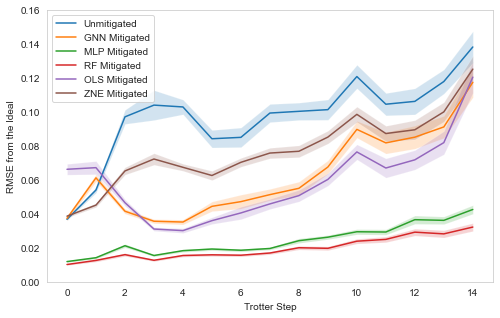

In [20]:
plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(8, 5))
steps = sorted(set(df.step))
legend_labels = ['Unmitigated', 'GNN Mitigated', 'MLP Mitigated', 'RF Mitigated', 'OLS Mitigated', 'ZNE Mitigated']
for i, col in enumerate(['RMSE_noisy', 'RMSE_gnn', 'RMSE_mlp', 'RMSE_rfr_list', 'RMSE_ols_full', 'RMSE_zne']):
    plt.plot(steps, df_mean[col], label=legend_labels[i])
    plt.fill_between(x=steps, y1=df_mean[col]-df_ste[col], y2=df_mean[col]+df_ste[col], alpha=0.2)
plt.legend()
plt.xlabel('Trotter Step')
plt.ylabel('RMSE from the Ideal')
plt.ylim([0, 0.16])
plt.grid(None)
plt.show()

In [ ]:
# df_hue = []
# for i in range(len(df)):
#     for col in ['RMSE_noisy', 'RMSE_rfr_list', 'RMSE_zne']:
#         df_hue.append([df.loc[i, 'step'], df.loc[i, col], col])
# df_hue = pd.DataFrame(df_hue)
# df_hue.columns = ['step', 'RMSE', 'name']
#
# plt.figure(figsize=(15, 5))
# plt.style.use({'figure.facecolor':'white'})
# g = sns.boxplot(data=df_hue, x='step', y='RMSE', hue='name')
# g.legend(title="")
# new_legend_labels = ['Unmitigated', 'Mitigated by RF', 'Mitigated by ZNE']
# for i in range(3):
#     g.legend_.texts[i].set_text(new_legend_labels[i])
# plt.xlabel('Trotter Steps')
# plt.ylabel('RMSE from Ideal Expectation Values')
# plt.show()

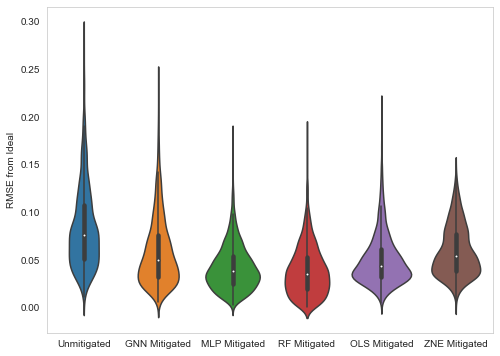

In [38]:
plt.figure(figsize=(8, 6))
ax = sns.violinplot(data=df[['RMSE_noisy', 'RMSE_gnn', 'RMSE_mlp', 'RMSE_rfr_list', 'RMSE_ols_full', 'RMSE_zne']])
# labels = ax.get_xticklabels()
ax.set_xticklabels(['Unmitigated', 'GNN Mitigated', 'MLP Mitigated', 'RF Mitigated', 'OLS Mitigated', 'ZNE Mitigated'])
plt.ylabel('RMSE from Ideal')
# plt.ylim([-0.02, 0.25])
ax.grid(False)
plt.show()

In [ ]:
# plt.figure()
# plt.style.use({'figure.facecolor':'white'})
# q = 3
# dist_noisy = df['noisy'].apply(lambda x: x[q]) - df['ideal'].apply(lambda x: x[q])
# sns.histplot(dist_noisy, kde=True, alpha=0.2, label='dist_noisy')
# for i in range(len(models)):
#     dist_model = df['noisy'].apply(lambda x: x[q]) - df[f'model_{i}'].apply(lambda x: x[q])
#     sns.histplot(dist_model, kde=True, alpha=0.2, label=f'dist_{models[i][1]}')
#
# plt.xlabel("Distance")
# plt.ylabel("Counts")
# plt.title(f"Distribution of distance to ideal on q{q}")
# plt.xlim([-0.35, 0.15])
# plt.ylim([0, 300])
# plt.legend()
# plt.show()

# Plot the distribution
# sns.histplot(dist_noisy, kde=True)
# plt.xlabel("Differences (Column2 - Column1)")
# plt.ylabel("Frequency")
# plt.title("Distribution of Differences between First Entries of Column2 and Column1")
# plt.show()